### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2018.csv')
df = df.iloc[::5, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [7]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [8]:
df.head()

,year,Post
0,2018,10 Habits That Make Anxiety Worse (And How to ...
5,2018,An Ode To AnxietyMy anxiety is a frightened bi...
10,2018,"The Brain, an Organ It IsOut of order, these w..."
15,2018,Why does anxiety find you when you are alone?W...
20,2018,The Mechanics of CopingIn my last conversation...


In [9]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [10]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [11]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['habits', 'that', 'make', 'anxiety', 'worse', 'and', 'how', 'to', 'avoid', 'having', 'them', 'unfortunately', 'anxiety', 'disorders', 'are', 'the', 'most', 'common', 'form', 'of', 'mental', 'illness', 'in', 'the', 'united', 'states', 'affecting', 'million', 'adults', 'over', 'the', 'age', 'of', 'roughly', 'of', 'the', 'population', 'anxiety', 'costs', 'more', 'than', 'billion', 'annually', 'in', 'mental', 'health', 'bills', 'which', 'shows', 'just', 'how', 'widespread', 'and', 'severe', 'this', 'disorder', 'has', 'become', 'with', 'so', 'many', 'people', 'suffering', 'from', 'anxiety', 'it', 'seems', 'of', 'utmost', 'importance', 'to', 'find', 'the', 'triggers', 'for', 'this', 'disorder', 'and', 'how', 'we', 'can', 'avoid', 'them', 'what', 'can', 'we', 'do', 'to', 'feel', 'better', 'you', 'll', 'find', 'the', 'answers', 'to', 'this', 'question', 'in', 'this', 'article', 'as', 'well', 'as', 'the', 'actual', 'habits', 'that', 'make', 'anxiety', 'worse', 'in', 'general', 'overthinking',

In [12]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [13]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [14]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['habits', 'that', 'make', 'anxiety', 'worse', 'and', 'how', 'to', 'avoid', 'having', 'them', 'unfortunately', 'anxiety', 'disorders', 'are', 'the', 'most', 'common', 'form', 'of', 'mental_illness', 'in', 'the', 'united_states', 'affecting', 'million_adults', 'over', 'the', 'age', 'of', 'roughly', 'of', 'the', 'population', 'anxiety', 'costs', 'more', 'than', 'billion', 'annually', 'in', 'mental_health', 'bills', 'which', 'shows', 'just', 'how', 'widespread', 'and', 'severe', 'this', 'disorder', 'has', 'become', 'with', 'so', 'many', 'people', 'suffering', 'from', 'anxiety', 'it', 'seems', 'of', 'utmost', 'importance', 'to', 'find', 'the', 'triggers', 'for', 'this', 'disorder', 'and', 'how', 'we', 'can', 'avoid', 'them', 'what', 'can', 'we', 'do', 'to', 'feel', 'better', 'you', 'll', 'find', 'the', 'answers', 'to', 'this', 'question', 'in', 'this', 'article', 'as', 'well', 'as', 'the', 'actual', 'habits', 'that', 'make', 'anxiety', 'worse', 'in', 'general', 'overthinking', 'literally',

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
data_words_nostops = remove_stopwords(data_words)
print("1")
data_words_bigrams = make_bigrams(data_words_nostops)
print("2")

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("3")

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)
print("4")

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)
print("5")

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
print("6")
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
print("7")
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
print("8")

# 6. Filter out least frequently used words
no_below = 0.02
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)
print("9")

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
print("10")

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)
print("11")

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=44,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

1
2
3
4
5
6
7
8
There are 1650 unique words in the dictionary, 1650 remain after filtering out lest frequent.
9
1650 remain after filtering out most commonly used words based on tfidf scores.
10
11


In [24]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(39,
  '0.449*"overthinke" + 0.000*"tackle" + 0.000*"roll" + 0.000*"sad" + '
  '0.000*"sentence" + 0.000*"shake" + 0.000*"reply" + 0.000*"tooth" + '
  '0.000*"text" + 0.000*"ready"'),
 (30,
  '0.279*"leg" + 0.196*"belong" + 0.175*"float" + 0.167*"birth" + '
  '0.039*"useless" + 0.000*"shake" + 0.000*"teen" + 0.000*"sad" + '
  '0.000*"sentence" + 0.000*"return"'),
 (9,
  '0.253*"light" + 0.194*"demon" + 0.159*"bright" + 0.153*"eye" + 0.078*"past" '
  '+ 0.065*"future" + 0.001*"reflect" + 0.000*"tear" + 0.000*"sentence" + '
  '0.000*"roll"'),
 (0,
  '0.173*"modern" + 0.151*"option" + 0.084*"stone" + 0.083*"counselor" + '
  '0.073*"counseling" + 0.056*"heal" + 0.056*"blind" + 0.054*"healing" + '
  '0.053*"mirror" + 0.052*"severe"'),
 (43,
  '0.226*"disorder" + 0.092*"trauma" + 0.079*"ptsd" + 0.077*"symptom" + '
  '0.068*"panic_attack" + 0.044*"phobia" + 0.042*"excessive" + '
  '0.033*"traumatic" + 0.027*"reaction" + 0.027*"attack"'),
 (3,
  '0.233*"god" + 0.119*"movie" + 0.105*"church" +

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.374469310015781


In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3630483490899214


In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [28]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,23.0,0.2575,"habit, relationship, food, drive, avoid, meal,...","[habit, make, anxiety, bad, avoid, unfortunate..."
1,1,11.0,0.2343,"realize, grow, real, dream, almost, yet, voice...","[ode, anxietymy, anxiety, frighten, live, ches..."
2,2,31.0,0.2026,"panic, travel, speak, social, group, approach,...","[brain, organ, isout, order, word, take, forma..."
3,3,32.0,0.1706,"confidence, afraid, student, trigger, aware, s...","[anxiety, find, alone, creep, least, expect, r..."
4,4,11.0,0.1794,"realize, grow, real, dream, almost, yet, voice...","[mechanic, copingin, last, conversation, gramp..."


In [29]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,23.0,0.2575,"habit, relationship, food, drive, avoid, meal,...","[habit, make, anxiety, bad, avoid, unfortunate..."
1,1,11.0,0.2343,"realize, grow, real, dream, almost, yet, voice...","[ode, anxietymy, anxiety, frighten, live, ches..."
2,2,31.0,0.2026,"panic, travel, speak, social, group, approach,...","[brain, organ, isout, order, word, take, forma..."
3,3,32.0,0.1706,"confidence, afraid, student, trigger, aware, s...","[anxiety, find, alone, creep, least, expect, r..."
4,4,11.0,0.1794,"realize, grow, real, dream, almost, yet, voice...","[mechanic, copingin, last, conversation, gramp..."
...,...,...,...,...,...
1282,1282,26.0,0.1358,"reduce, effect, behavior, belief, originally_p...","[genius, app, anxiety, need, downloadanxiety, ..."
1283,1283,11.0,0.2643,"realize, grow, real, dream, almost, yet, voice...","[vision, boarddo, dream, start, get, mono, ear..."
1284,1284,11.0,0.3317,"realize, grow, real, dream, almost, yet, voice...","[seed, social, anxiety, entryi, feel, slight, ..."
1285,1285,11.0,0.1574,"realize, grow, real, dream, almost, yet, voice...","[bliss, pill, anxiety, age, dec]"


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

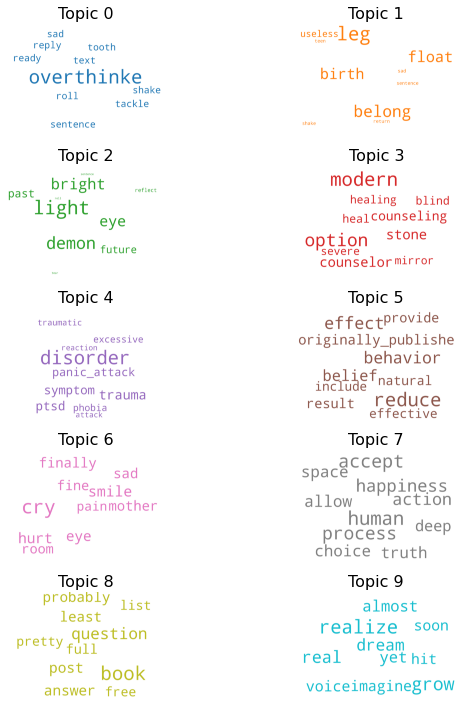

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
df_dominant_topic.to_csv("Medium2018.csv")

In [32]:
num_topics=44
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
for i in range(0,num_topics):
    print(topic_words[i])
    
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
print(df2.shape)
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2

['modern', 'option', 'stone', 'counselor', 'counseling', 'heal', 'blind', 'healing', 'mirror', 'severe']
['phone', 'walk', 'check', 'ocd', 'boyfriend', 'laugh', 'neck', 'mountain', 'smell', 'grab']
['grateful', 'gratitude', 'laugh', 'music', 'relax', 'listen', 'ear', 'box', 'choose', 'relaxation']
['god', 'movie', 'church', 'fly', 'bird', 'forgive', 'syndrome', 'sky', 'dad', 'special']
['book', 'question', 'post', 'answer', 'probably', 'least', 'full', 'list', 'free', 'pretty']
['kid', 'school', 'mom', 'college', 'boy', 'parent', 'dad', 'car', 'wife', 'son']
['courage', 'pray', 'strength', 'gift', 'strong', 'faith', 'growth', 'spirit', 'failure', 'weakness']
['silence', 'empty', 'silent', 'crowd', 'stupid', 'dance', 'update', 'differently', 'switch', 'air']
['therapy', 'therapist', 'partner', 'issue', 'episode', 'chronic', 'psychiatrist', 'admit', 'date', 'relationship']
['light', 'demon', 'bright', 'eye', 'past', 'future', 'reflect', 'tear', 'sentence', 'roll']
['health', 'increase', 

,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[modern, option, stone, counselor, counseling,..."
1,2014,Medium,1,"[phone, walk, check, ocd, boyfriend, laugh, ne..."
2,2014,Medium,2,"[grateful, gratitude, laugh, music, relax, lis..."
3,2014,Medium,3,"[god, movie, church, fly, bird, forgive, syndr..."
4,2014,Medium,4,"[book, question, post, answer, probably, least..."
5,2014,Medium,5,"[kid, school, mom, college, boy, parent, dad, ..."
6,2014,Medium,6,"[courage, pray, strength, gift, strong, faith,..."
7,2014,Medium,7,"[silence, empty, silent, crowd, stupid, dance,..."
8,2014,Medium,8,"[therapy, therapist, partner, issue, episode, ..."
9,2014,Medium,9,"[light, demon, bright, eye, past, future, refl..."


In [33]:
df2.to_csv("topic_words_m2018.csv")

In [64]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [65]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)


range(2, 100, 6)
[0.4254655362692674, 0.3635186432566275, 0.3571198970573902, 0.35513748127998046, 0.3557723497820075, 0.3476863977110459, 0.3438076814713477, 0.3492693136809675, 0.3364948559504193, 0.3367756016744421, 0.3368939250542269, 0.3381165887472013, 0.33075002354386457, 0.33137967031408, 0.3296830606006802, 0.3310048650060942, 0.32972481695309924]


(44, 0.00546163220961976, 0.3492693136809675)

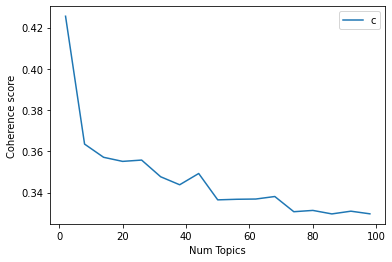

In [66]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)